In [1]:
# importing all needed functions
import os
import shutil
import json
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from fast_histogram import histogram1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
from astropy.io import ascii
import matplotlib.patches as mpatches
from matplotlib import rc,rcParams
from astropy.table import Table
%matplotlib inline
# %matplotlib notebook
from astropy.io import fits
from numpy import arange
import json
import subprocess
from Calculating_det_angles import estimate_source_angles_detectors #importing ma'ams function
import matplotlib.image as mpimg

# importing all needed functions
import os
from pathlib import Path
from astropy.io import fits
import numpy as np
import glob
import time
from Tools import tools
import traceback
from tqdm import tqdm
import matplotlib.pyplot as plt
from numba import jit
import os
import shutil
import line_profiler
from scipy import stats
from line_profiler import profile
%load_ext line_profiler
import pwkit.bblocks
import sys
import pandas as pd

import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", message="Polyfit may be poorly conditioned")

zero_files = 0

In [2]:
def delete_folders(directory, folder_list):
    for folder in folder_list:
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            try:
                shutil.rmtree(folder_path)
                print(f"Deleted folder: {folder}")
            except Exception as e:
                print(f"Error deleting folder {folder}: {str(e)}")
        else:
            print(f"{folder} is not a folder or does not exist.")

@jit(nopython=True)
def filter_counts(times, channels, min_ch, max_ch, trigtime):
    """
    Filter count data based on channel range and subtract trigtime.
    
    :param times: Array of event times
    :param channels: Array of channel numbers
    :param min_ch: Minimum channel number
    :param max_ch: Maximum channel number
    :param trigtime: Trigger time to be subtracted
    :return: Filtered and adjusted count data
    """
    counts = []
    for t, ch in zip(times, channels):
        if min_ch <= ch <= max_ch:
            counts.append(t - trigtime)
    return np.array(counts)

@profile
def process_folder(folder, bin_list,data_no,r,chr1,chr2,data_set_path,source_data_set_path,error_folders,zero_files = zero_files, plot = False):
    """
    Process a single folder of data.
    
    :param folder: Name of the folder to process
    :param bin_list: List of bin sizes to use
    """
    try:
        # Extract event information from folder name
        event_type, event = folder.split("_")

        mod_folder = folder[:-1] if folder [-1] == 'd' else folder


        # check if the file is processed
        data_file_path = Path(data_set_path) / f"{event_type}_{event}"
        if data_file_path.exists():
            # print(f"File already processed: {data_file_path}")
            return

        # Construct file pattern and find matching files
        file_pattern = str(Path(source_data_set_path) / mod_folder / 'current' / '*_tte_*')
        NaI_detector = glob.glob(file_pattern)


        # Read data from FITS file
        with fits.open(NaI_detector[0], memmap=True) as hdul:
            all_count_data = hdul[2].data
            trigtime = float(hdul[2].header['TRIGTIME'])

        # Extract times and channels from all_count_data
        times = all_count_data['TIME'].astype(float)
        channels = all_count_data['PHA'].astype(int)

        # Filter counts for different channel ranges
        counts_1 = times - trigtime
        counts_2 = filter_counts(times, channels, chr2[0], chr2[1], trigtime)

        data_array = []
        
        print('the bin list',bin_list)
        # Process both count ranges
        for i in bin_list:
            sep_sig = []
            ch_no = 1
            for counts in [counts_1,counts_2]:
                print('the bin size',i)
                # Calculate range and bin size
                range_min = min(counts) #-data_no * i * r
                range_max = max(counts) # data_no * i * (1-r)
                bin_size = i

                # print(range_max)
                # print(range_min)
    
                # Create histogram
                bin_edges = np.arange(range_min, range_max, bin_size)
                hist, edges = np.histogram(counts, bins=bin_edges)
                data_no = len(hist) + 1
                hist = adjust_zeros(hist)
                bin_widths = edges[1:]-edges[:-1]
                hrates = hist / bin_size

                # Perform Bayesian Block Analysis
                bayes = pwkit.bblocks.bin_bblock(widths = bin_widths, counts = hist, p0 = 0.01)

                # Getting the results of the analysis
                block_starts = (bayes.get('blockstarts') * i) + range_min
                block_stops = block_starts + bayes.get('widths')
                bins = np.array(list(block_starts) + list([block_stops[-1]]))
                rates = bayes.get('rates')

                # Find indices where rates are non-zero
                non_zero_indices = np.nonzero(rates)[0]
                
                # Select rates that are non-zero
                rates = rates[non_zero_indices]
                
                # Select corresponding bins
                bins = np.concatenate([bins[non_zero_indices], [bins[non_zero_indices[-1] + 1]]])

                sigw = bins[-2] - bins[1]

                bk2 = bins[1] - (5 * bin_size)
                bk3 = bins[-2] + (5 * bin_size)
                bk1 = bk2 - sigw - (50 * bin_size) if (bk2 - sigw - (50 * bin_size)) > bins[0] else bins[0]
                bk4 = bk3 + sigw + (50 * bin_size) if (bk3 + sigw + (50 * bin_size)) < bins[-1] else bins[-1]

                # bk2 = bins[1]  # 
                # bk3 = bins[-2] # 
                # bk1 = bins[0]  # 
                # bk4 = bins[-1] # 
                
                bkgd = [(bk1,bk2),(bk3,bk4)]

                # Check if background is proper
                bkgd_check = bk1<bk2<bk3<bk4

                # Checking for signal
                # Checks False alarm probability p0, number of bins, and if background is detected around trigger
                if bayes.get('finalp0') >= 0.05 or len(bins)<4 or not(bk2 - 5 <= 0 <= bk3 + 5) or not bkgd_check:
                    # print('background',bkgd)
                    # print(bkgd_check)
                    # print('p0',bayes.get('finalp0'))
                    # print('bins', bins)
                    # print('no bins', len(bins))
                
                    # if plot:
                    #     print('no signal')
                    #     plt.title(f'{folder} light curve ; ch = {ch_no} ;bin size = {bin_size}s')
                    #     plt.stairs(hrates, edges)
                    #     plt.show()
                    #     plt.title(f'{folder} light curve ; ch = {ch_no} ;bin size = {bin_size}s')
                    #     plt.stairs(rates, bins)
                    #     plt.show()
                    # print('no signal')
                    # print(i,ch_no)
                    signal = np.zeros(data_no-1).astype(np.int32) # send no signal
                                    
                else:
                    y = hrates
                    x = (edges[1:] + edges[:-1]) / 2
                    bkgd_pol,_ = best_fit_polynomial(x, y, bkgd)

                    # Create mask for y between bk2 and bk3
                    mask = (x >= bk2) & (x <= bk3)

                    # Apply the mask and take the maximum of 0 and y - bkgd_pol(x)
                    signal = np.zeros(data_no-1).astype(np.int32)
                    signal[mask] = np.maximum(0, (y[mask] - bkgd_pol(x[mask]))).astype(np.int32)
                    
                    if plot:
                        plt.figure(figsize=(10,6))
                        plt.title(f'{folder} bayesian blockslight curve ; ch = {ch_no} ;bin size = {bin_size}s')
                        plt.stairs(rates, bins)
                        plt.show()
                        # Plot the results
                        plt.figure(figsize=(10,6))
                        plt.stairs(hrates,edges)
                        plt.xlabel('Time (s)')
                        plt.ylabel('rates')
                        plt.title(f'{folder} light curve ; ch = {ch_no} ;bin size = {bin_size}s')
                        # Plot each shaded area
                        for i, (x1, x2) in enumerate(bkgd):
                            plt.axvspan(x1, x2, alpha=0.3, color='red',label = 'background selection') 
                        # make sure most things are visible
                        if min(edges) < counts.min():
                            plt.gca().set_xlim(left=counts.min())
                        if max(edges) > counts.max():
                            plt.gca().set_xlim(right=counts.max())
                        plt.axvline(x=0, color='red', linestyle='--', linewidth=0.5)
                        # Evaluate the background polynomial for plotting
                        bkgd_y = bkgd_pol(x)
                        
                        # Check if the background blows up
                        if np.any(np.abs(bkgd_y) > 10 * np.max(np.abs(y))) or np.any(np.abs(bkgd_y) < 0.1 * np.min(np.abs(y[y != 0]))):                
                            # Plot the background within the limits
                            mask = (bkgd_y >= plt.ylim()[0]) & (bkgd_y <= plt.ylim()[1])
                            plt.plot(x[mask], bkgd_y[mask], '--', label='background')
                        else:
                            # If it doesn't blow up, plot normally
                            plt.plot(x, bkgd_y, '--', label='background')
                        plt.show()

                        # signal plot
                        plt.figure(figsize=(10,6))
                        plt.title(f'{folder} background subtracted light curve ; ch = {ch_no} ;bin size = {bin_size}s')
                        plt.axvline(x=0, color='red', linestyle='--', linewidth=0.5)
                        plt.xlabel('Time (s)')
                        plt.ylabel('rates')
                        plt.stairs(signal,edges)
                        plt.show()

                break

                # updatae channel number and save signal
                ch_no = ch_no + 1               
                sep_sig.extend(signal)
                

            # Accumulate histogram data
            data_array.extend(sep_sig)

        # Convert accumulated data to numpy array
        data_array = np.array(data_array)

        if data_array.shape[0] != len(bin_list) * 2 * (data_no-1):
            print('something may have gone wrong in ', folder)
            print(data_array.shape, len(bin_list) * 2 * (data_no-1))
        
        if plot:
            print('shape', data_array.shape)

        if np.all(data_array == 0):
            zero_files = zero_files + 1
            

    except Exception as e:
        # Handle and log any errors
        print(f'error {e} in {folder}')
        # traceback.print_exc()
        error_folders.append(folder)     

    return zero_files   

def adjust_zeros(arr):
    # Create a copy of the input array
    result = np.copy(arr)
    
    # Find first non-zero element
    first_non_zero = np.argmax(arr != 0)
    
    # Find last non-zero element
    last_non_zero = len(arr) - np.argmax(arr[::-1] != 0) - 1
    
    # Replace value after leading zeros with zero if there are leading zeros
    if first_non_zero > 0:
        result[first_non_zero] = 0
    
    # Replace value before trailing zeros with zero if there are trailing zeros
    if last_non_zero < len(arr) - 1:
        result[last_non_zero] = 0
    
    return result

def best_fit_polynomial(x, y, background_intervals):
    # Filter data to include only background intervals
    mask = np.zeros(len(x), dtype=bool)
    for start, end in background_intervals:
        mask |= (x >= start) & (x <= end)
    
    x_bg = x[mask]
    y_bg = y[mask]
    
    best_order = 0
    best_polynomial = None
    best_r_squared = -np.inf
    
    for order in range(1, 5):  # Test polynomials of order 1 to 4
        coeffs = np.polyfit(x_bg, y_bg, order)
        p = np.poly1d(coeffs)
        
        # Calculate R-squared
        y_pred = p(x_bg)
        r_squared = 1 - np.sum((y_bg - y_pred)**2) / np.sum((y_bg - np.mean(y_bg))**2)
        
        # Perform F-test to compare with lower order model
        if order > 1:
            f_statistic = ((r_squared - prev_r_squared) / (order - prev_order)) / \
                          ((1 - r_squared) / (len(x_bg) - order - 1))
            p_value = 1 - stats.f.cdf(f_statistic, 1, len(x_bg) - order - 1)
            
            if p_value < 0.05 and r_squared > best_r_squared:
                best_order = order
                best_polynomial = p
                best_r_squared = r_squared
        else:
            best_order = order
            best_polynomial = p
            best_r_squared = r_squared
        
        prev_order = order
        prev_r_squared = r_squared
    
    return best_polynomial, best_order

def full_plot(x,y,bkgd,bkgd_pol,peak = 0,peak_time = 0):
        # Create the plot
        plt.figure(figsize=(12, 5))
        plt.plot(x,y,label = 'data')

        # Plot each shaded area
        for i, (x1, x2) in enumerate(bkgd):
            plt.axvspan(x1, x2, alpha=0.3, color='red',label = 'background selection') 
        
        check_poly = np.poly1d([0,1])
        if not np.all(bkgd_pol.coef == check_poly.coef):
            # Evaluate the background polynomial
            bkgd_y = bkgd_pol(x)
            
            # Check if the background blows up
            if np.any(np.abs(bkgd_y) > 10 * np.max(np.abs(y))) or np.any(np.abs(bkgd_y) < 0.1 * np.min(np.abs(y[y != 0]))):                
                # Plot the background within the limits
                mask = (bkgd_y >= plt.ylim()[0]) & (bkgd_y <= plt.ylim()[1])
                plt.plot(x[mask], bkgd_y[mask], '--', label='background')
            else:
                # If it doesn't blow up, plot normally
                plt.plot(x, bkgd_y, '--', label='background')
        
        # If it blows up, limit the y-axis
        y_min, y_max = np.min(y), np.max(y)
        y_range = y_max - y_min
        plt.ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
        plt.axvline(x=0,ls='--' ,alpha = 0.5, linewidth=1)

        if peak == 0 and peak_time == 0:
            pass
        else:
            plt.scatter(peak_time,peak, s=40, c='k', marker='*', label='peak')

        plt.legend()
        plt.show()



start
total :  4374


Processing folders:   0%|          | 0/4374 [00:00<?, ?folder/s]

the bin list [0.1, 1]
the bin size 0.1


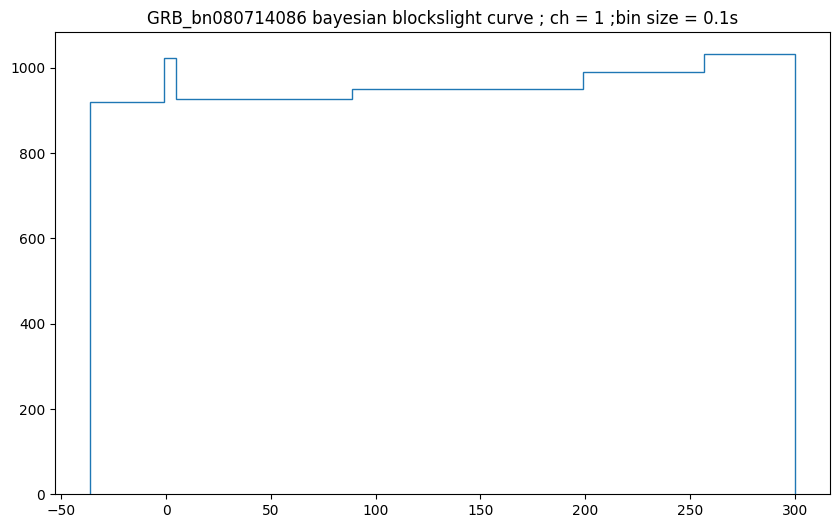

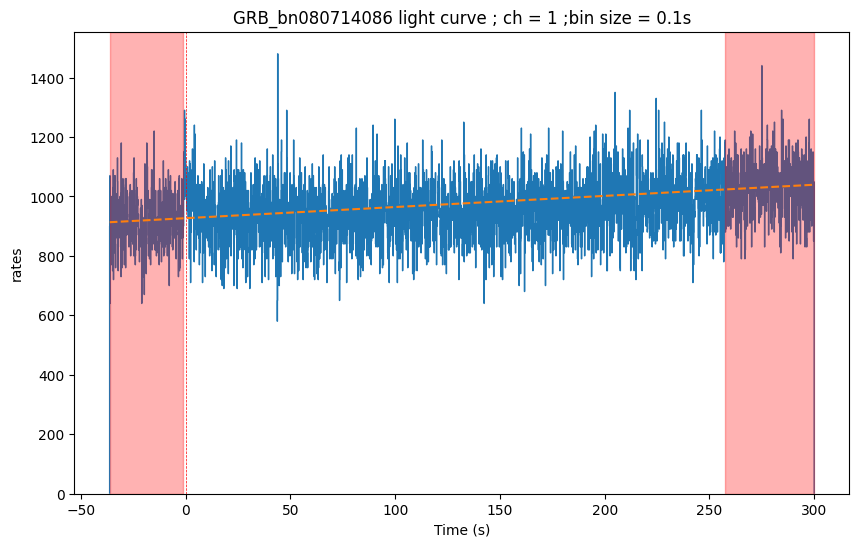

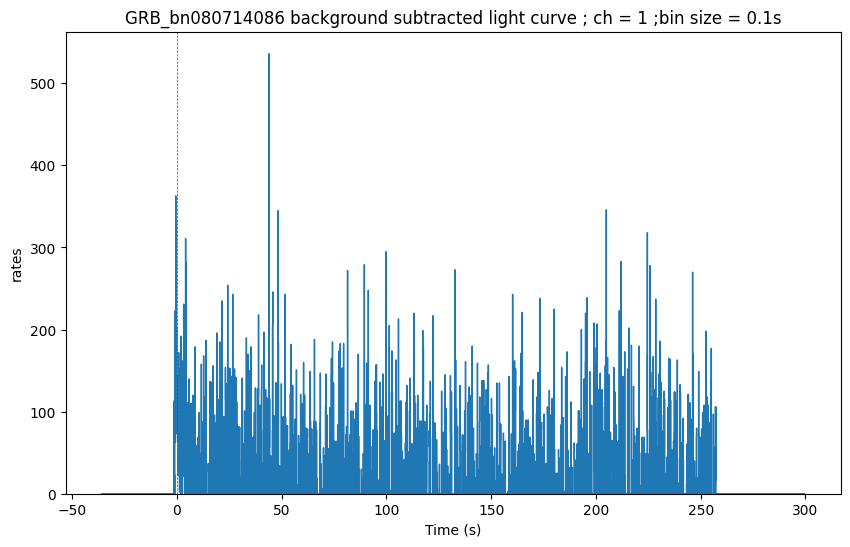

the bin size 1


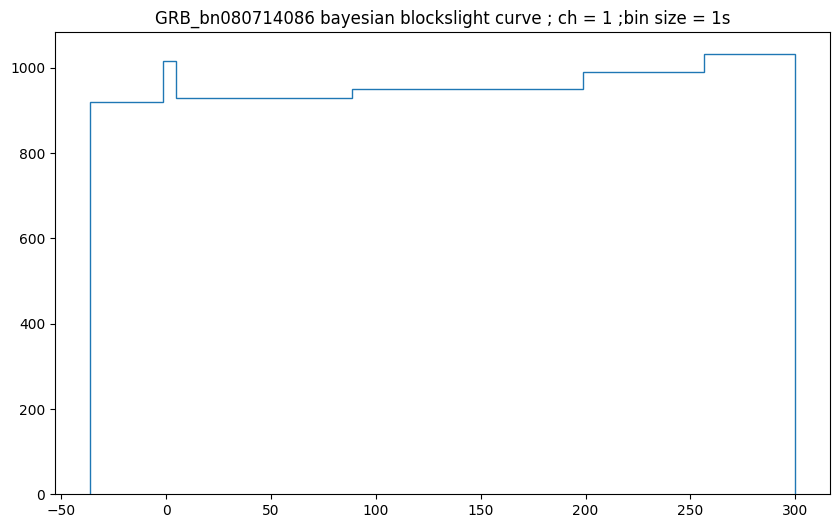

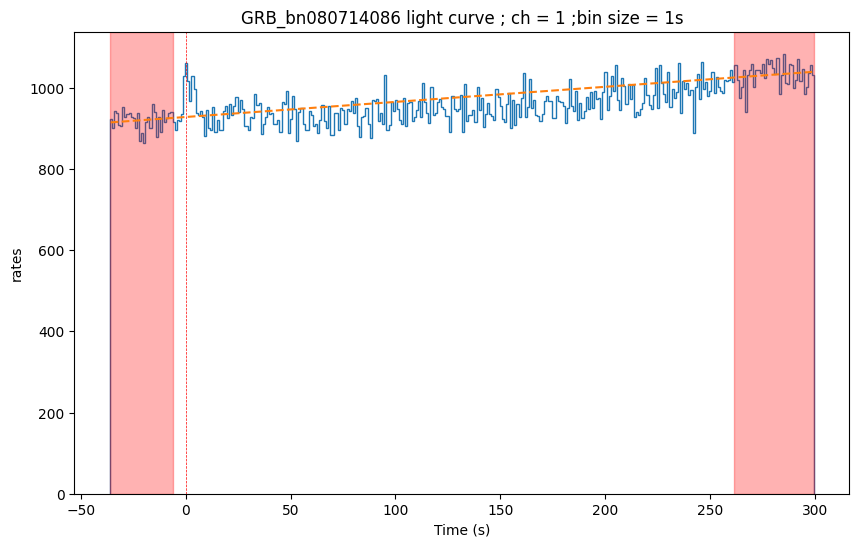

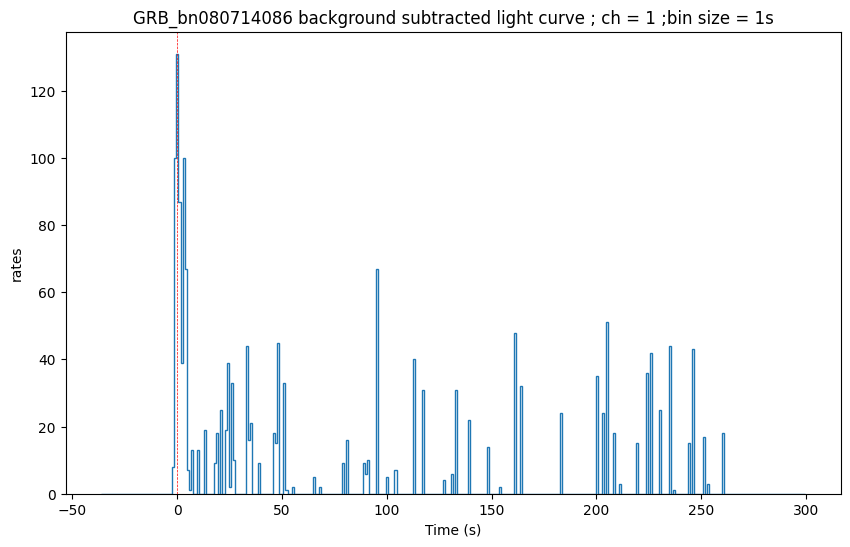

Processing folders:   0%|          | 1/4374 [00:18<22:07:19, 18.21s/folder]

something may have gone wrong in  GRB_bn080714086
(0,) 1344
shape (0,)
the bin list [0.1, 1]
the bin size 0.1
the bin size 1


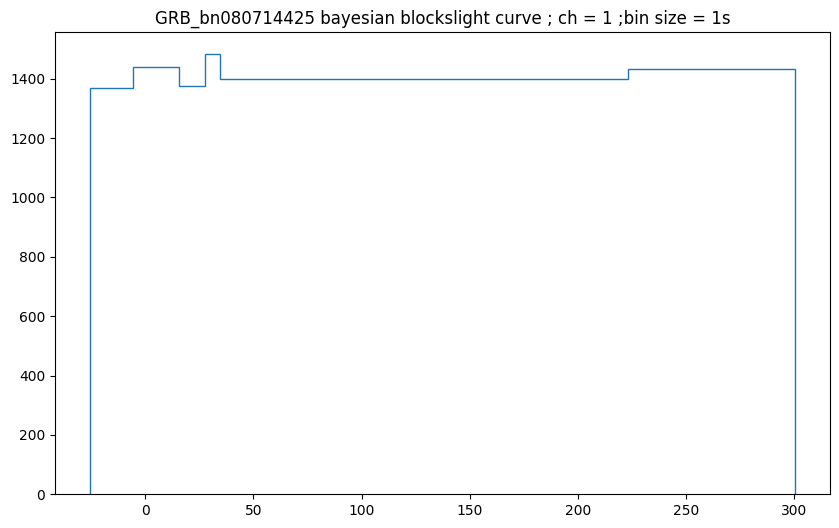

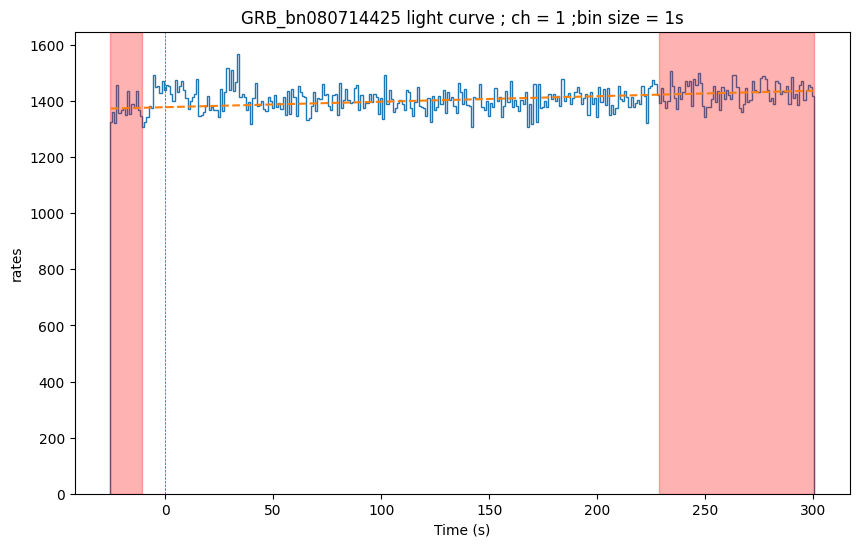

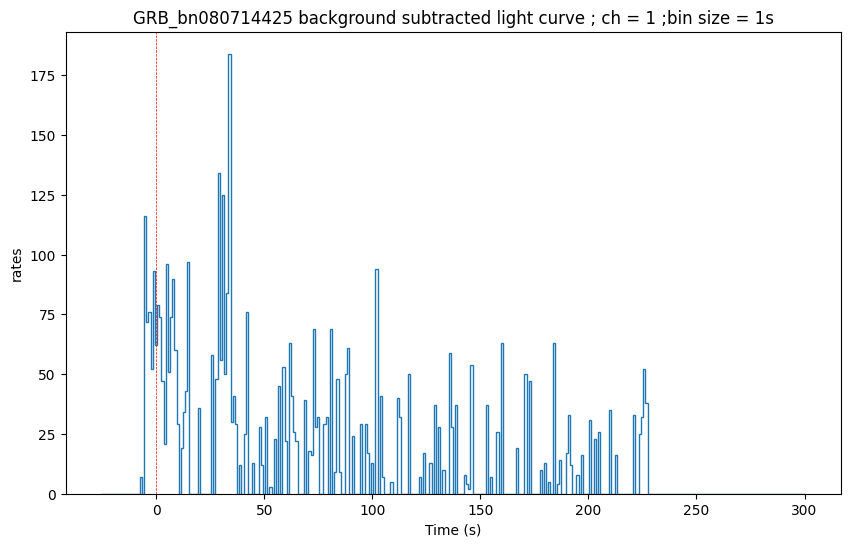

Processing folders:   0%|          | 2/4374 [00:26<15:01:23, 12.37s/folder]

something may have gone wrong in  GRB_bn080714425
(0,) 1304
shape (0,)
the bin list [0.1, 1]
the bin size 0.1


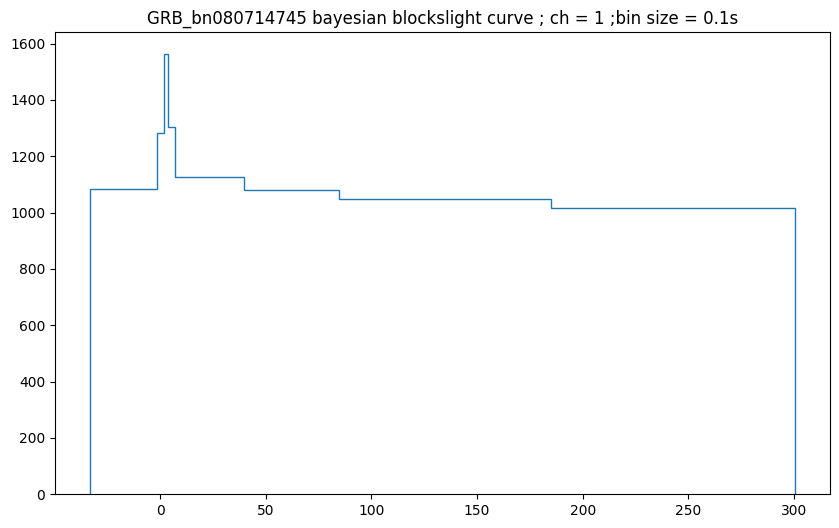

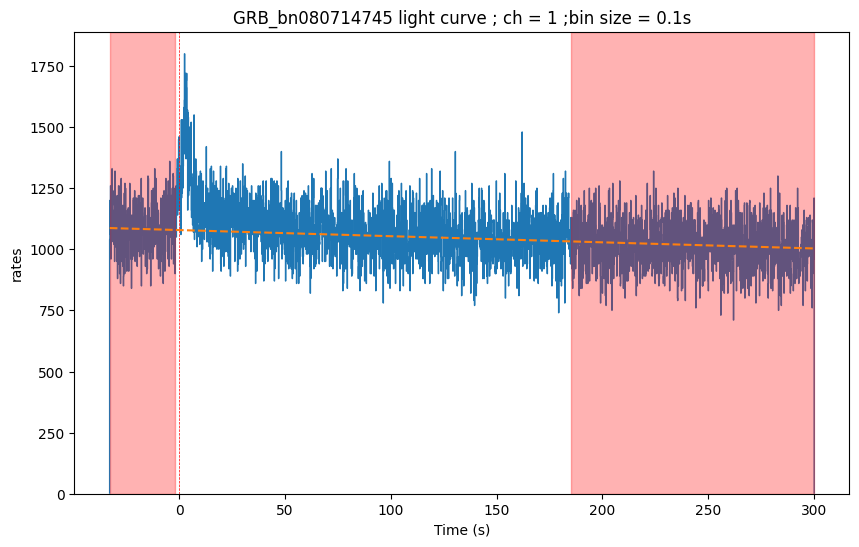

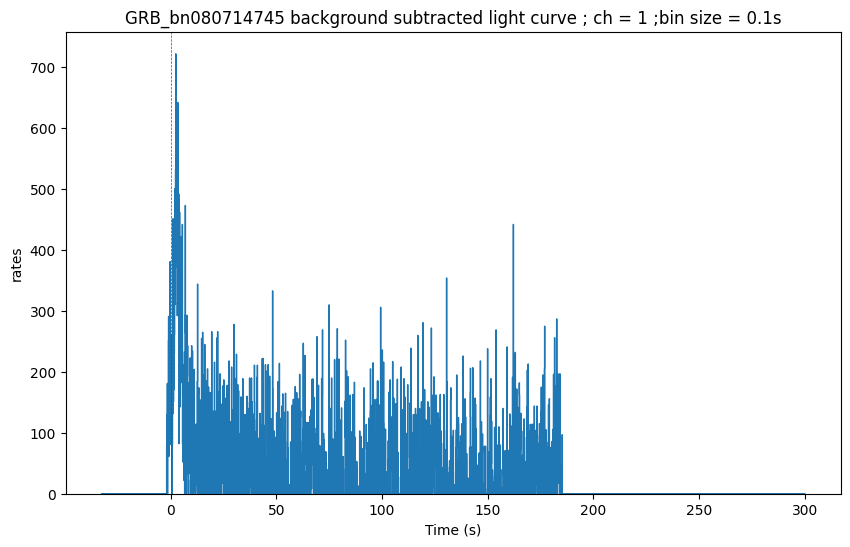

the bin size 1


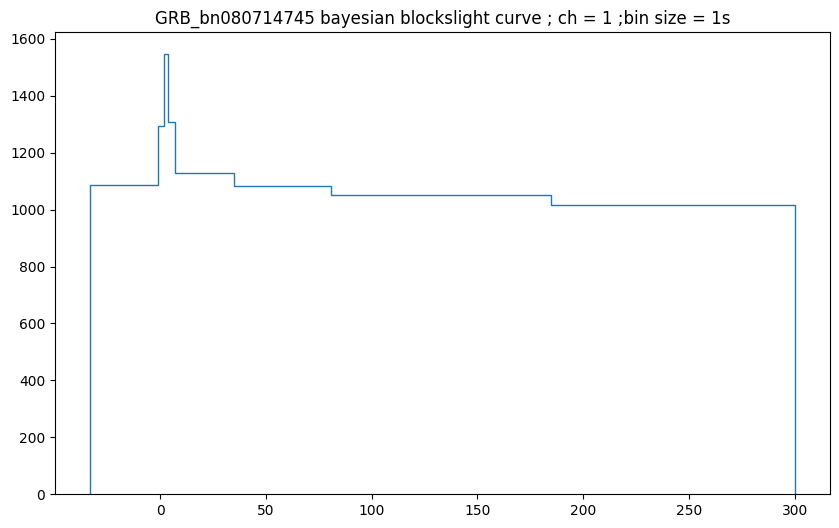

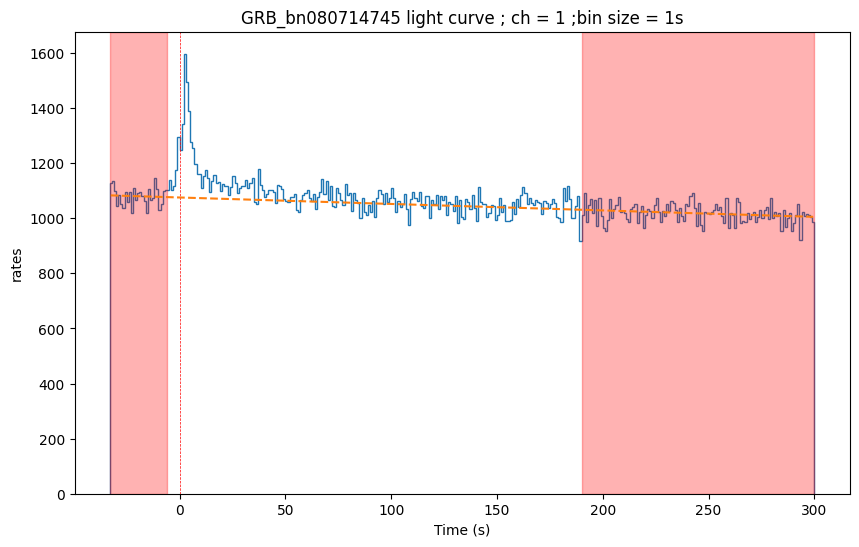

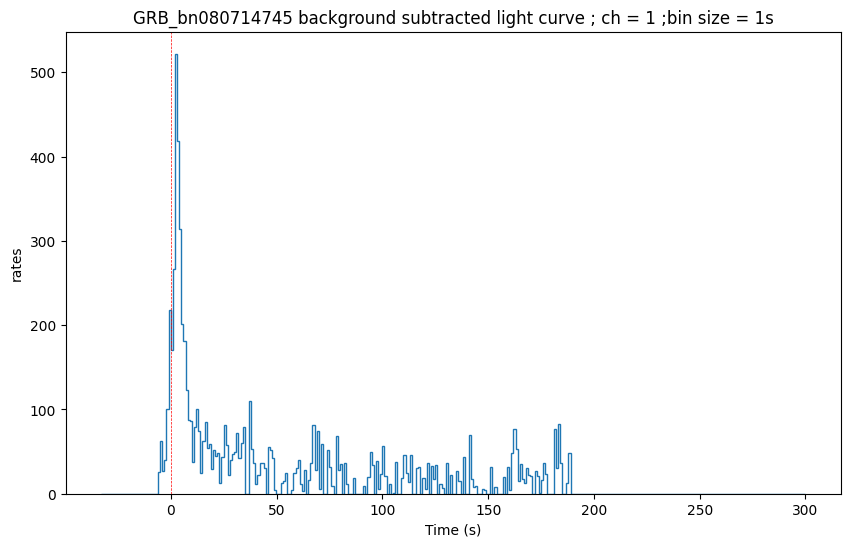

Processing folders:   0%|          | 3/4374 [00:39<15:09:35, 12.49s/folder]

something may have gone wrong in  GRB_bn080714745
(0,) 1332
shape (0,)
the bin list [0.1, 1]
the bin size 0.1


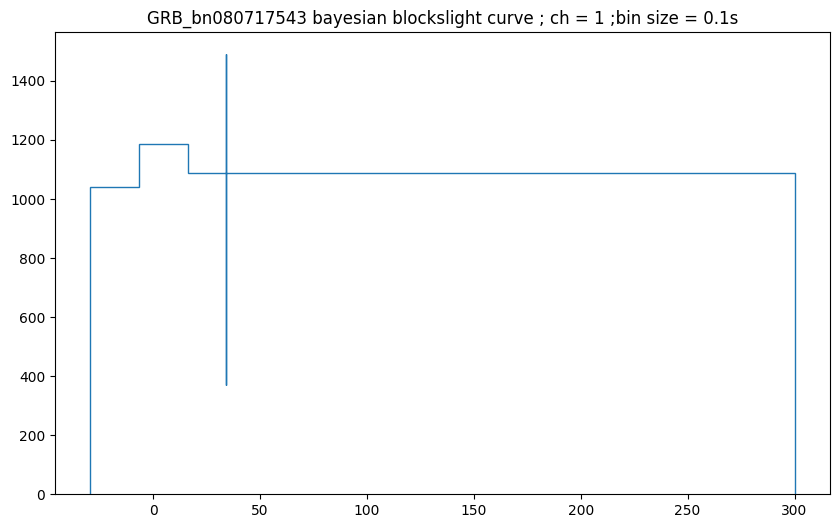

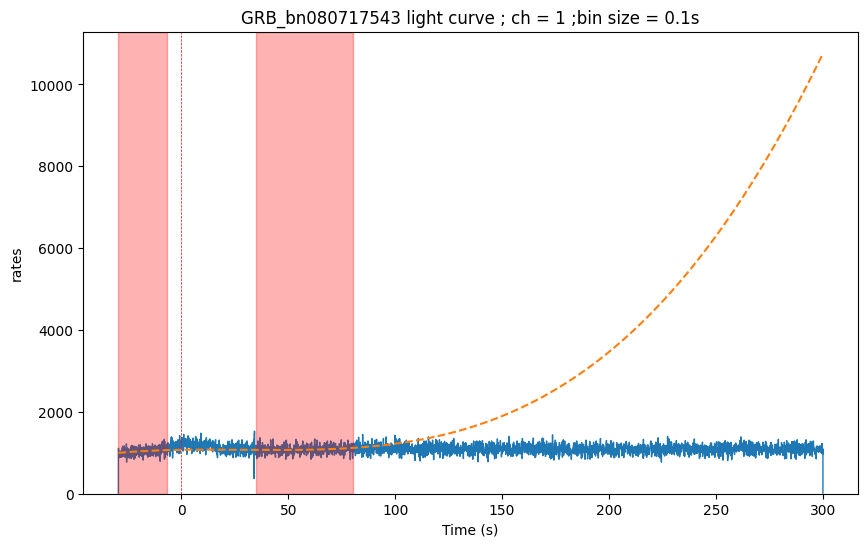

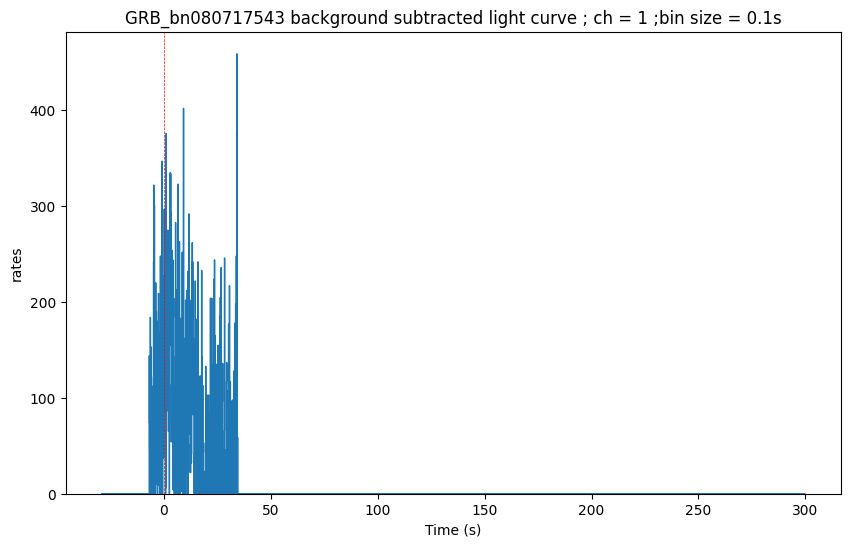

the bin size 1


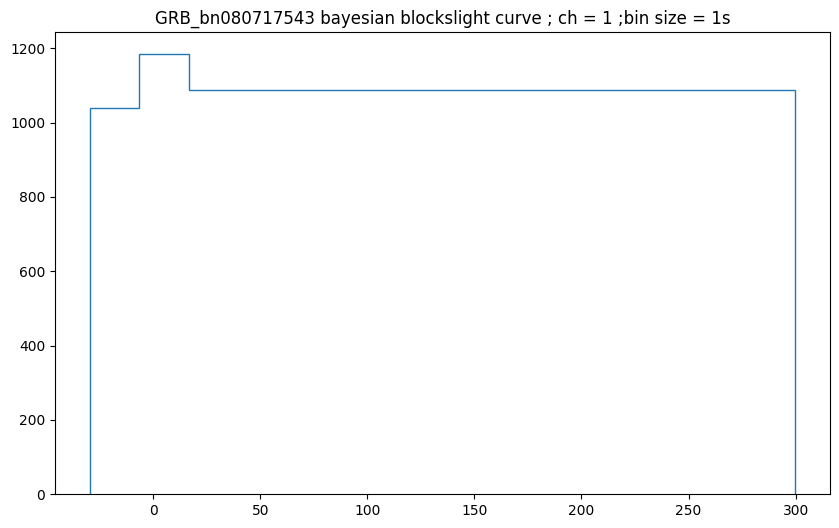

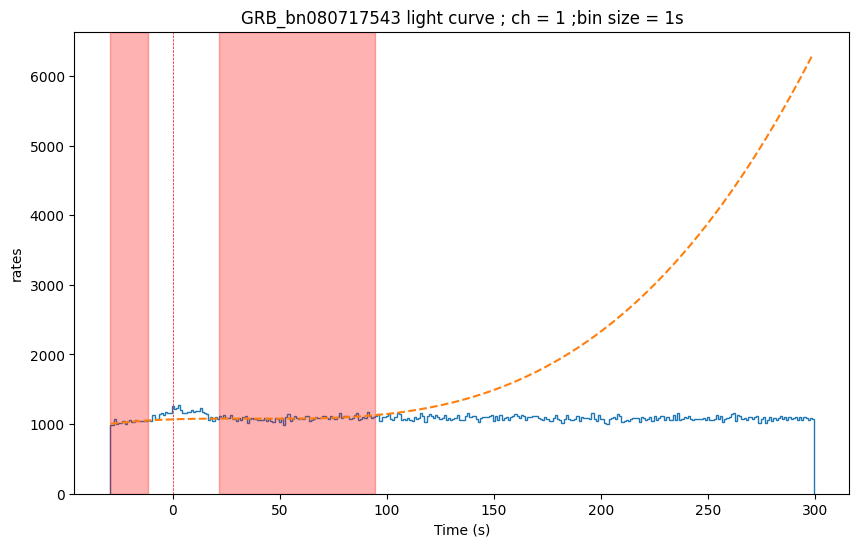

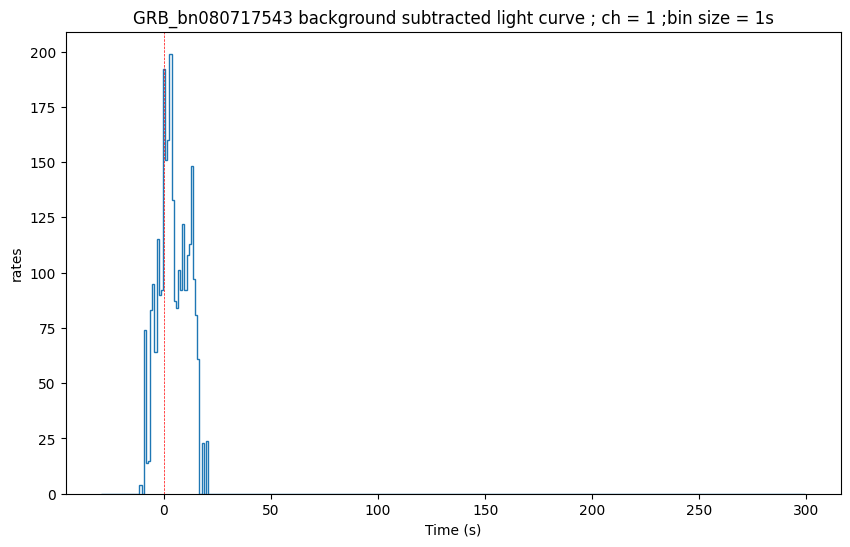

Processing folders:   0%|          | 4/4374 [00:52<15:37:23, 12.87s/folder]

something may have gone wrong in  GRB_bn080717543
(0,) 1316
shape (0,)
the bin list [0.1, 1]
the bin size 0.1


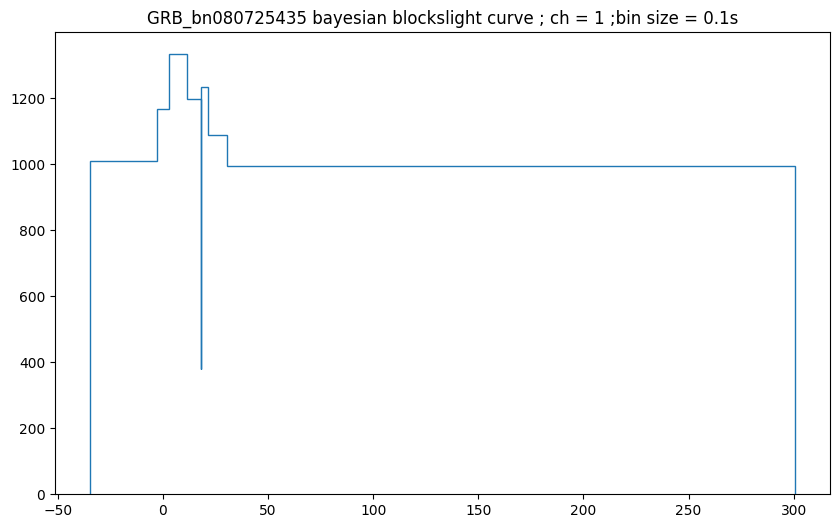

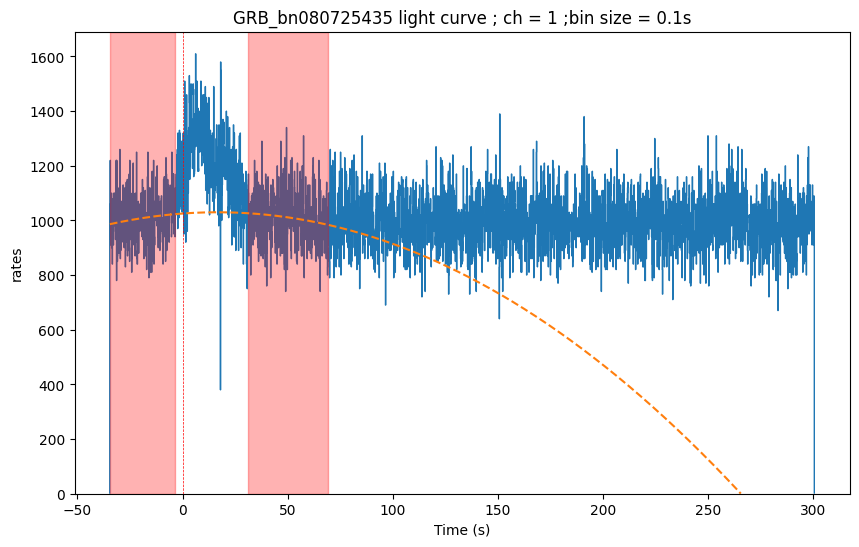

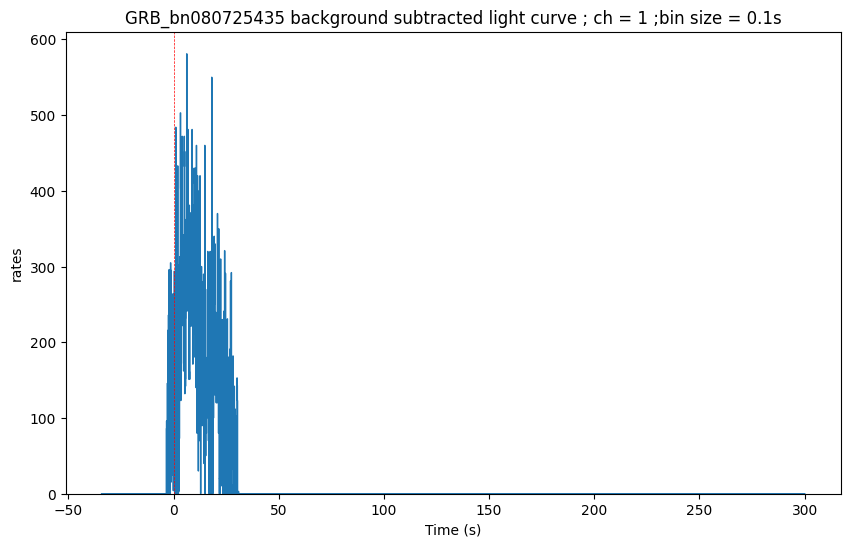

the bin size 1


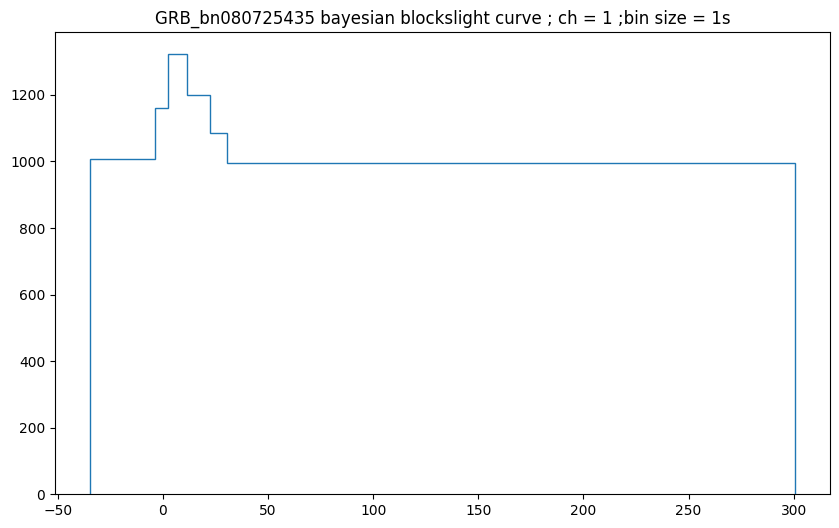

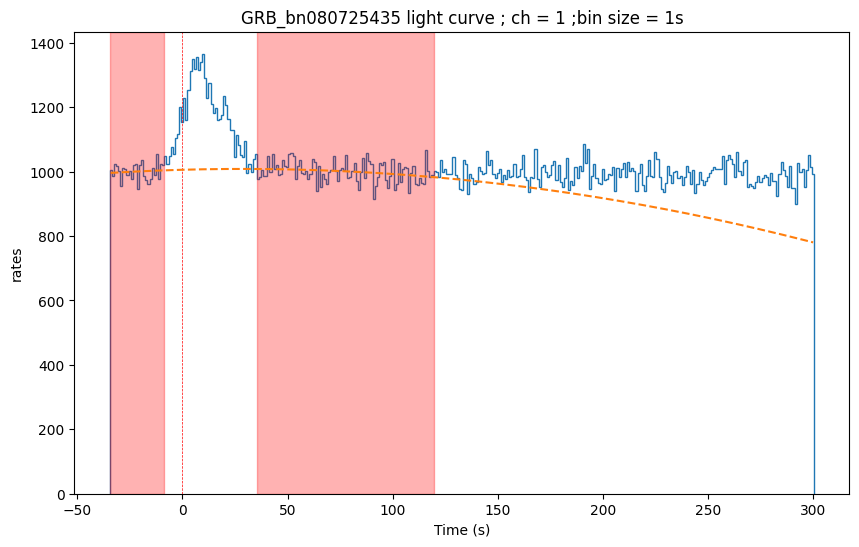

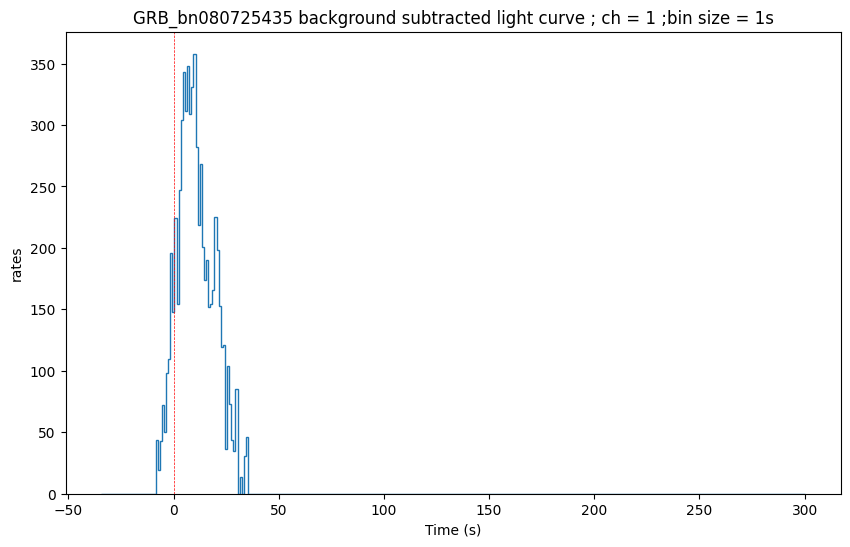

Processing folders:   0%|          | 5/4374 [01:06<16:08:22, 13.30s/folder]

something may have gone wrong in  GRB_bn080725435
(0,) 1340
shape (0,)
the bin list [0.1, 1]
the bin size 0.1


Processing folders:   0%|          | 6/4374 [01:07<10:55:21,  9.00s/folder]

the bin size 1
something may have gone wrong in  GRB_bn080831053
(0,) 500
shape (0,)
the bin list [0.1, 1]
the bin size 0.1


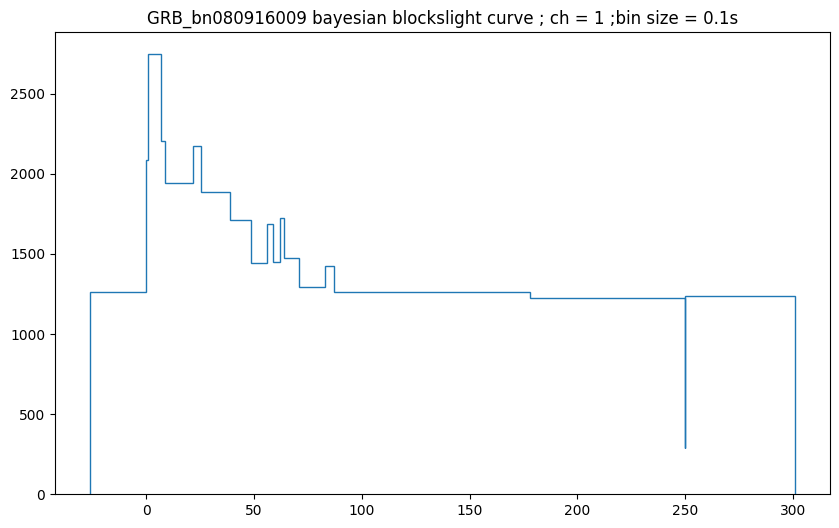

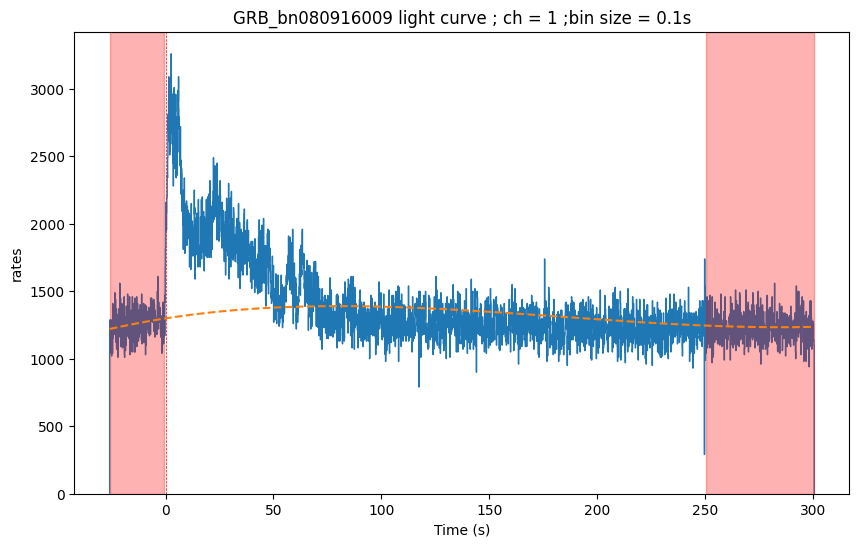

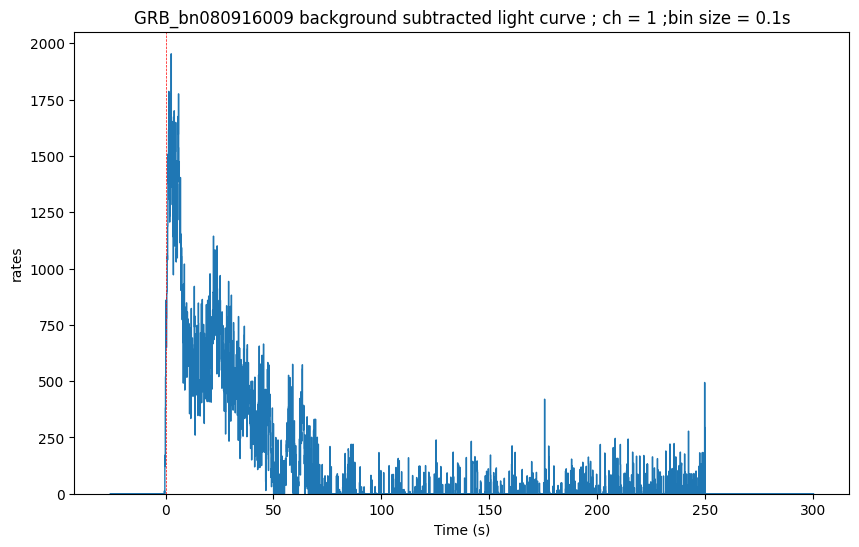

the bin size 1


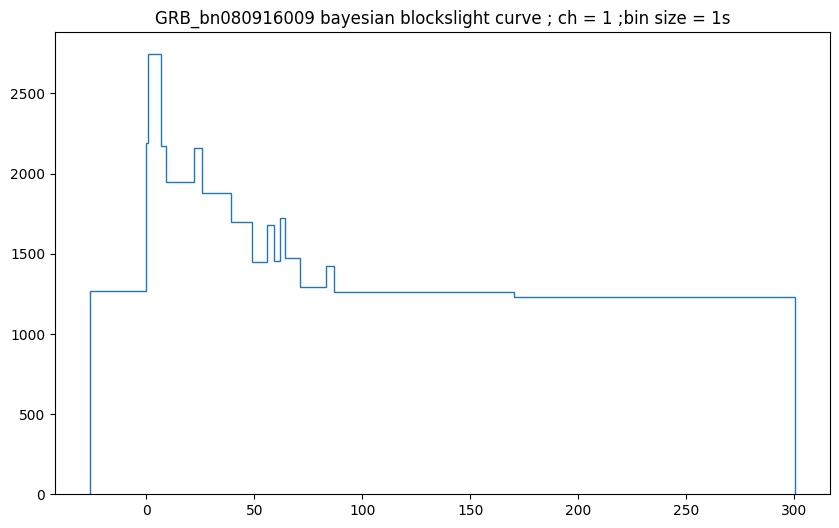

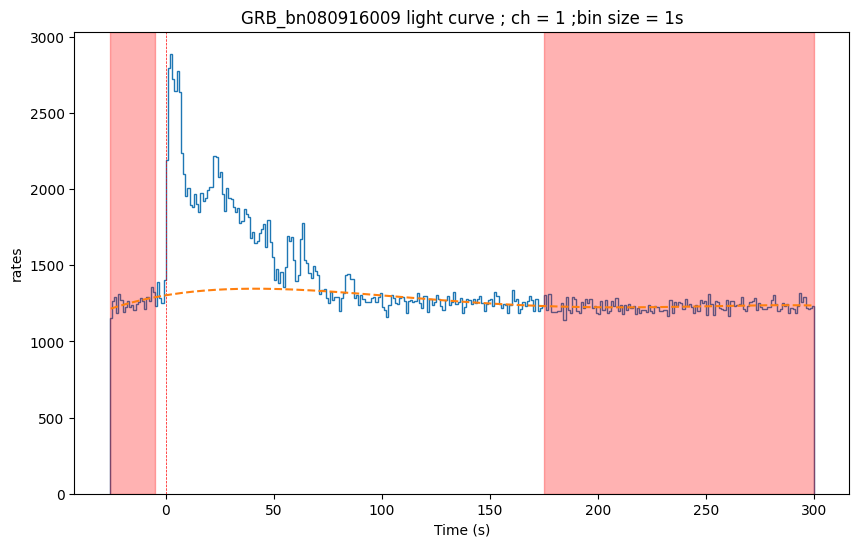

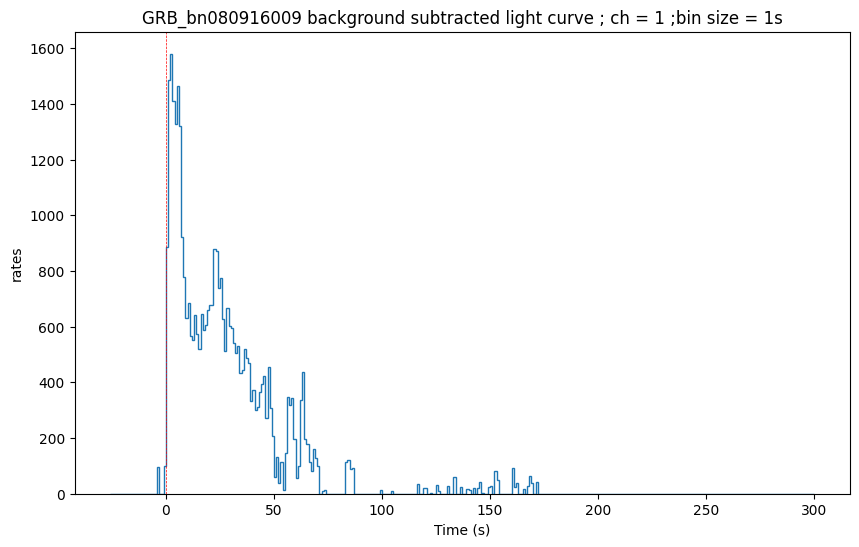

Processing folders:   0%|          | 7/4374 [01:22<13:19:16, 10.98s/folder]

something may have gone wrong in  GRB_bn080916009
(0,) 1304
shape (0,)
the bin list [0.1, 1]
the bin size 0.1


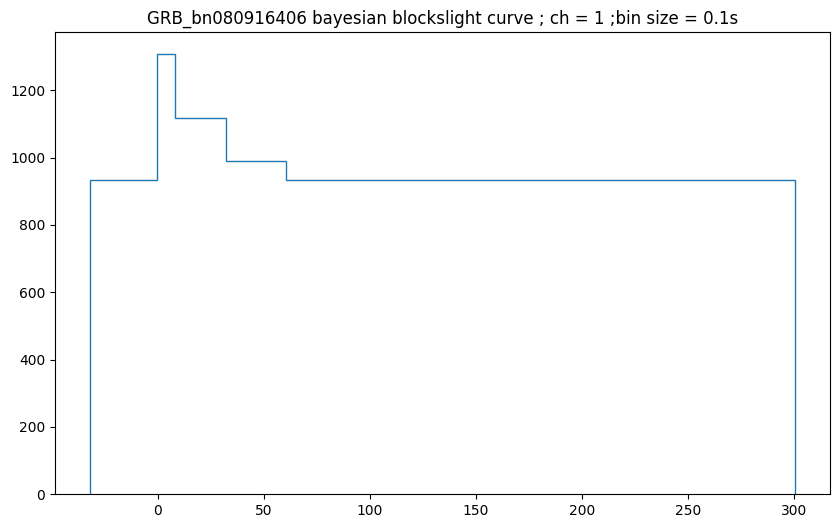

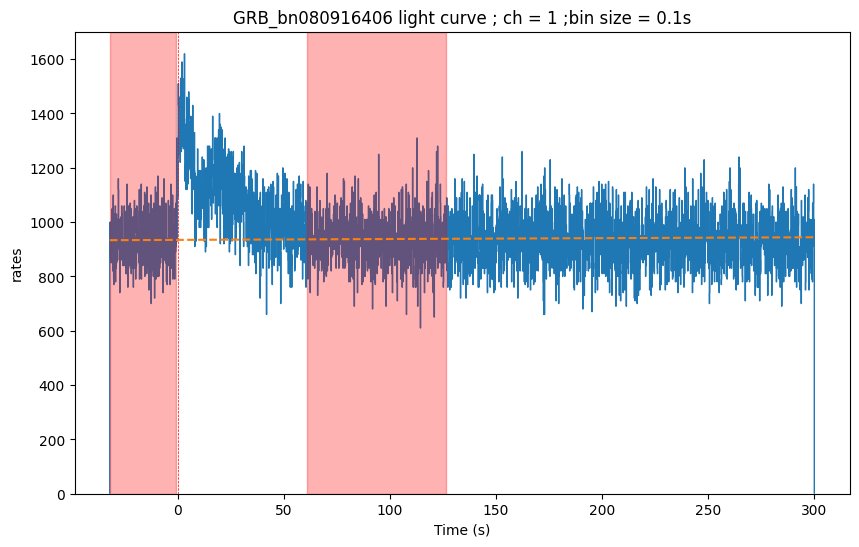

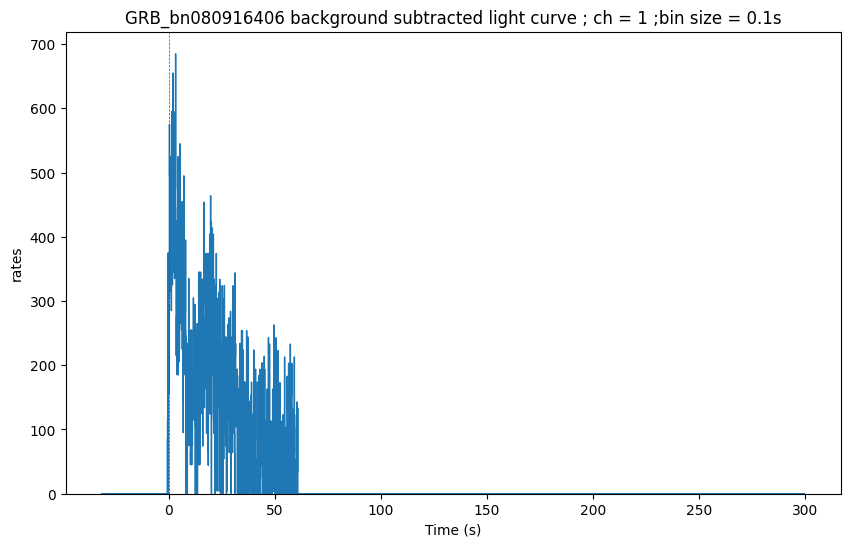

the bin size 1


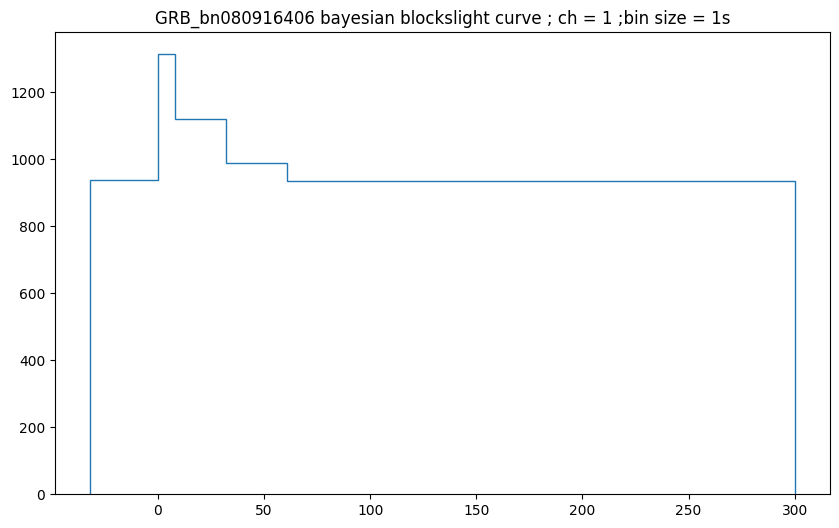

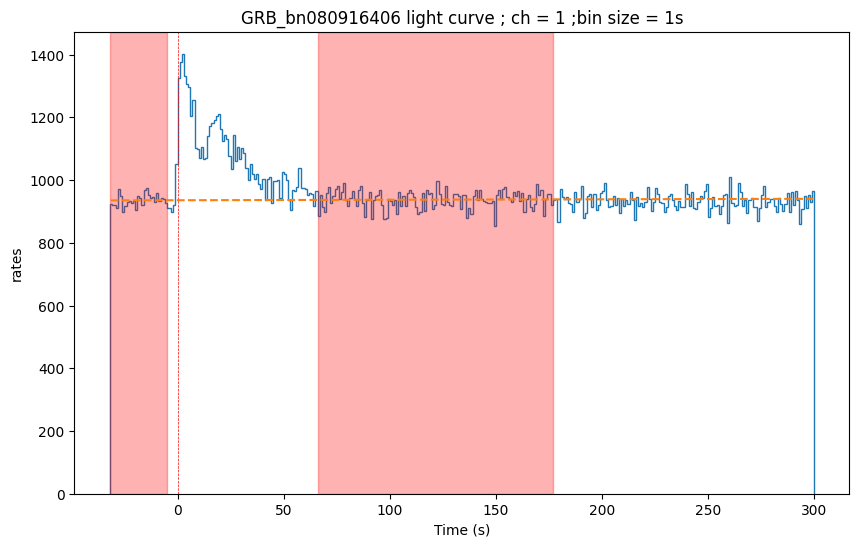

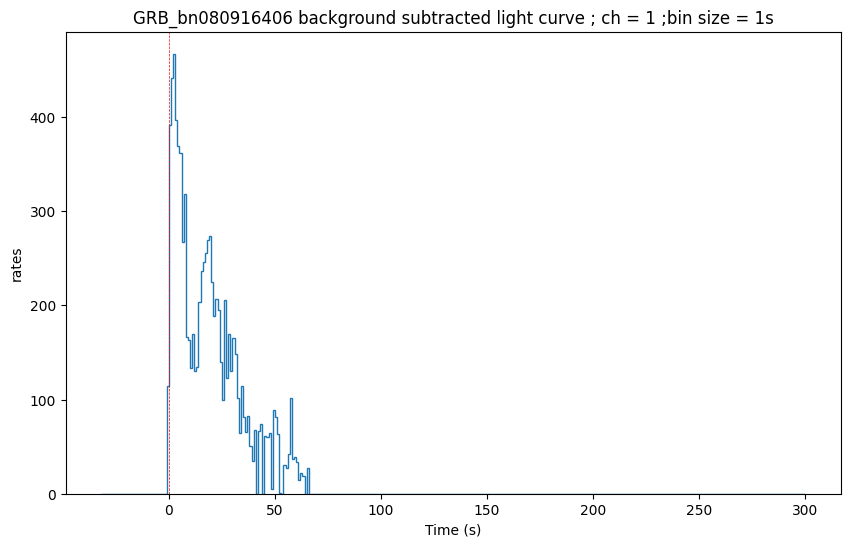

Processing folders:   0%|          | 8/4374 [01:35<14:07:05, 11.64s/folder]

something may have gone wrong in  GRB_bn080916406
(0,) 1328
shape (0,)
the bin list [0.1, 1]
the bin size 0.1


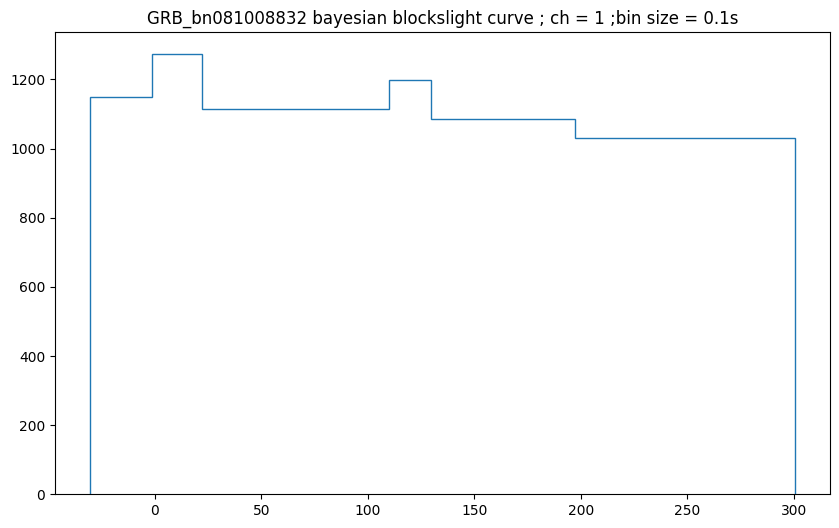

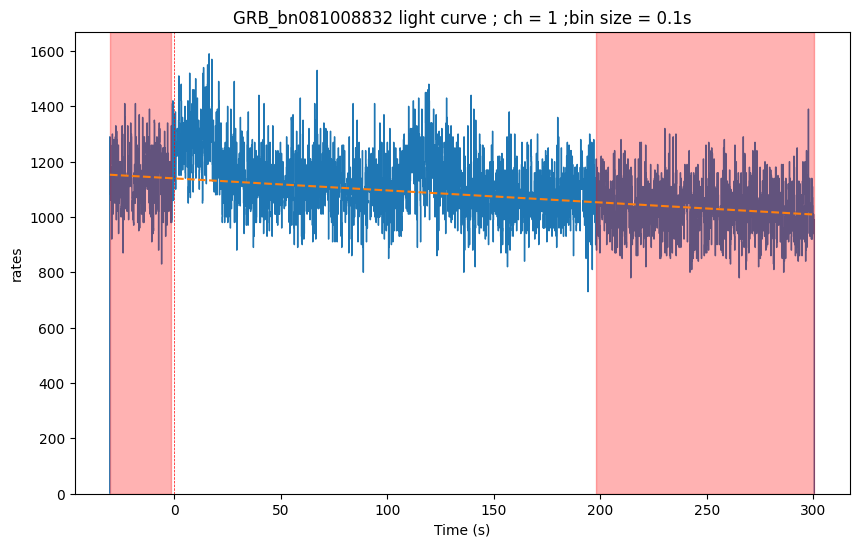

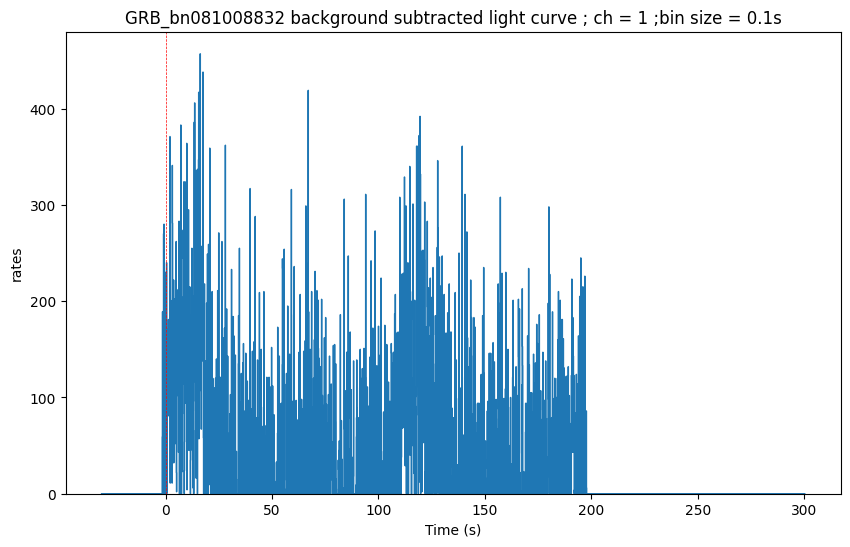

the bin size 1


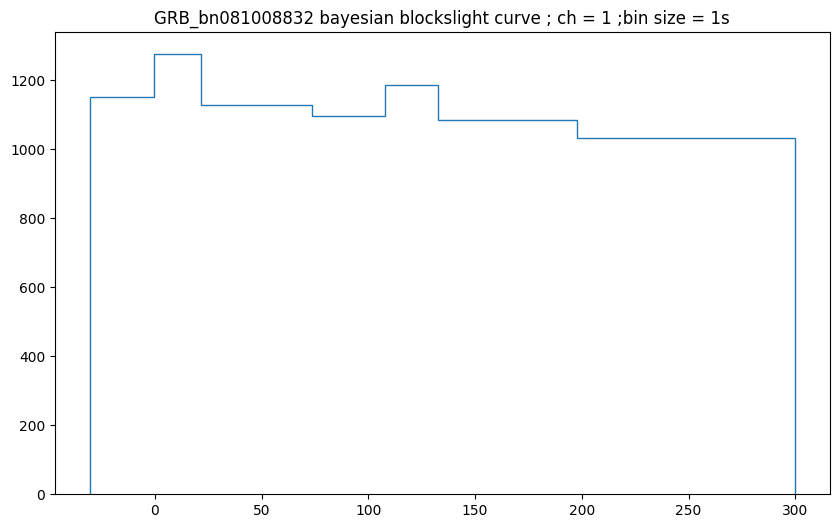

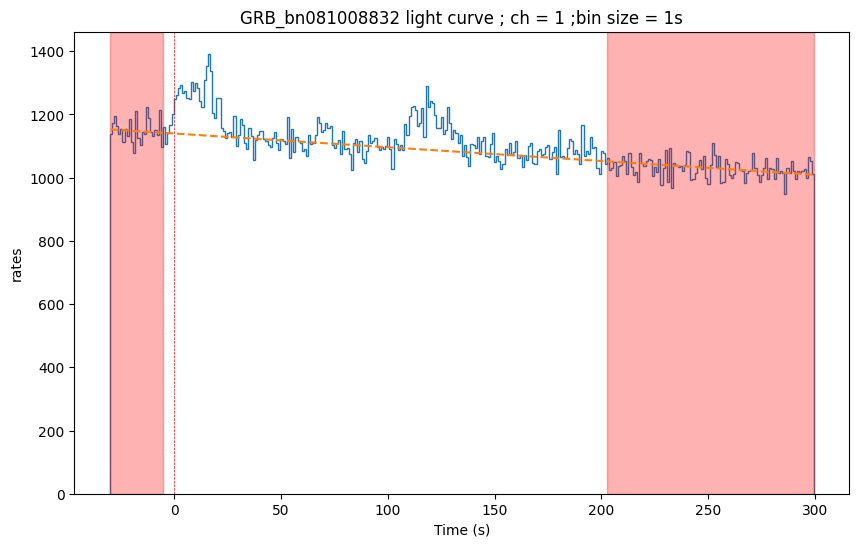

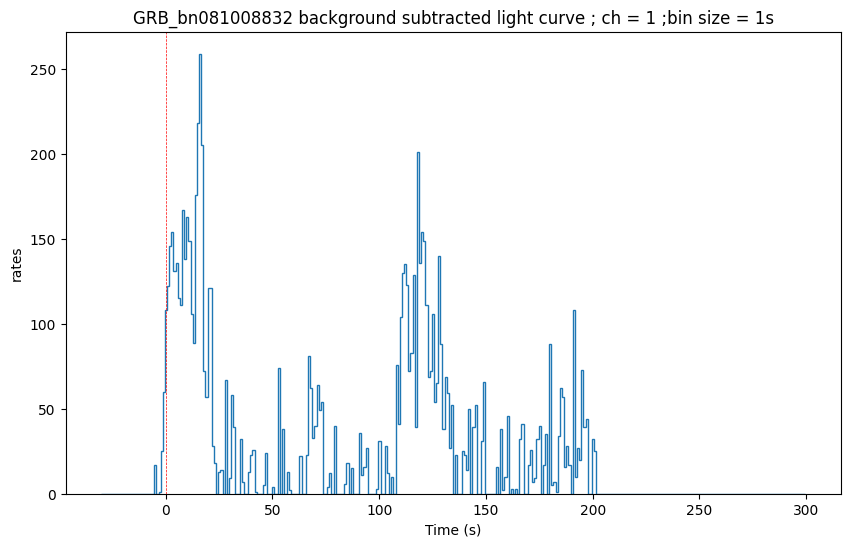

Processing folders:   0%|          | 9/4374 [01:47<14:25:58, 11.90s/folder]

something may have gone wrong in  GRB_bn081008832
(0,) 1320
shape (0,)
the bin list [0.1, 1]
the bin size 0.1


In [3]:
# name of the data set
source_data_set_path = r"D:\GRB_data\500_data_set"

# Get a list of all folders in the specified directory
folders = [str(folder) for folder in os.listdir(source_data_set_path) if os.path.isdir(os.path.join(source_data_set_path, folder))]

# list of bin sizes
bin_list =  [0.1,1] # [0.001,0.004,0.016,0.064,0.256,1.024,4.096] # [0.004,0.016,0.064,0.256,1.024,4.096] # [0.001, 0.005, 0.01, 0.1, 0.5, 1, 5] # 

# number of datapoints in a light curve
data_no = 500

# ratio of pre-trigger to post-trigger
r = 0.25

# channel range
chr1 = [0, 127]
chr2 = [0, 127]

print('start')
print('total : ',len(folders))

# Measure execution time
start_time = time.time()

error_folders = []

profiler = line_profiler.LineProfiler()
profiler.add_function(process_folder)
profiler.enable_by_count()

zero_files = 0

# processing test data
c = 10
for folder in tqdm(folders[:], desc="Processing folders", unit="folder"):
   if 'GRB' in folder:
      zero_files = process_folder(folder,bin_list,data_no,r,chr1,chr2,'test_path',source_data_set_path,error_folders, zero_files,plot=True)    
      c = c - 1
      if c < 1:
         break
# processing train data
# print('saving processed events to ',train_path)
# for folder in tqdm(train_events[:], desc="Processing folders", unit="folder"):
#    zero_files = process_folder(folder,bin_list,data_no,r,chr1,chr2,train_path,source_data_set_path,error_folders,zero_files, plot=False)    

         
# profiler.print_stats()
# print('\n----------------------------------------------------------------------------\n\nevents', folders, ' in folder')
end_time = time.time()

# Calculate and print the elapsed time
elapsed_time = end_time - start_time
print(f"Elapsed Time: {elapsed_time:.2f} seconds")

print("errors occured in:")
for folder in error_folders:
    print(folder)